# Восстановление золота из руды

Необходимо подготовить прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий. Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды для оптимизации производства и для запуска предприятия с безубыточными характеристиками. Можно использовать данные с параметрами добычи и очистки. 

Нам нужно:
1. Обработать данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

## Подготовка данных

### Импортируем библиотеки и модули

In [1]:
import pandas as pd

import matplotlib.pyplot as plt

import numpy as np

import warnings

from numpy.random import RandomState

from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor


### Отключим некритические предупреждения в коде

In [2]:
warnings.filterwarnings("ignore")

### Откроем файлы с данными

In [3]:
gold_recovery_train_new = pd.read_csv('/datasets/gold_recovery_train_new.csv')
gold_recovery_test_new = pd.read_csv('/datasets/gold_recovery_test_new.csv')
gold_recovery_full_new = pd.read_csv('/datasets/gold_recovery_full_new.csv')

### Посмотрим общую информацию о файлах

In [4]:
gold_recovery_train_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


In [5]:
gold_recovery_test_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

In [6]:
gold_recovery_full_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


Видно, что в тестовой выборке отсутствует ряд признаков: "final.output", "primary_cleaner.output".

### Проверим датасеты на наличие явных дубликатов

In [7]:
gold_recovery_train_new.duplicated().sum()

0

In [8]:
gold_recovery_test_new.duplicated().sum()

0

In [9]:
gold_recovery_full_new.duplicated().sum()

0

### Посмотрим на количество пропущенных значений

In [10]:
gold_recovery_train_new.isna().sum()

date                                            0
final.output.concentrate_ag                     1
final.output.concentrate_pb                     1
final.output.concentrate_sol                  211
final.output.concentrate_au                     0
                                             ... 
secondary_cleaner.state.floatbank5_a_level      1
secondary_cleaner.state.floatbank5_b_air        1
secondary_cleaner.state.floatbank5_b_level      1
secondary_cleaner.state.floatbank6_a_air        2
secondary_cleaner.state.floatbank6_a_level      1
Length: 87, dtype: int64

In [11]:
gold_recovery_test_new.isna().sum()

date                                           0
primary_cleaner.input.sulfate                  4
primary_cleaner.input.depressant               5
primary_cleaner.input.feed_size                0
primary_cleaner.input.xanthate                 4
primary_cleaner.state.floatbank8_a_air         0
primary_cleaner.state.floatbank8_a_level       0
primary_cleaner.state.floatbank8_b_air         0
primary_cleaner.state.floatbank8_b_level       0
primary_cleaner.state.floatbank8_c_air         0
primary_cleaner.state.floatbank8_c_level       0
primary_cleaner.state.floatbank8_d_air         0
primary_cleaner.state.floatbank8_d_level       0
rougher.input.feed_ag                          0
rougher.input.feed_pb                          0
rougher.input.feed_rate                        3
rougher.input.feed_size                        1
rougher.input.feed_sol                        21
rougher.input.feed_au                          0
rougher.input.floatbank10_sulfate              5
rougher.input.floatb

In [12]:
gold_recovery_full_new.isna().sum()

date                                            0
final.output.concentrate_ag                     1
final.output.concentrate_pb                     1
final.output.concentrate_sol                  211
final.output.concentrate_au                     0
                                             ... 
secondary_cleaner.state.floatbank5_a_level      1
secondary_cleaner.state.floatbank5_b_air        1
secondary_cleaner.state.floatbank5_b_level      1
secondary_cleaner.state.floatbank6_a_air        2
secondary_cleaner.state.floatbank6_a_level      1
Length: 87, dtype: int64

Во всех датасетах имеются пропуски в различных столбцах. Столбец "date" заполнен во всех  датасетах. 

### Посмотрим на числовые характеристики в датасетах

In [13]:
pd.set_option('display.max_rows', None)
gold_recovery_train_new.describe()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,14148.000000,14148.000000,13938.000000,14149.000000,14149.000000,14149.000000,14049.000000,14144.000000,14149.000000,14129.000000,...,14143.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14147.000000,14148.000000
mean,5.142034,10.132960,9.202849,44.003792,66.518832,9.607035,2.597298,10.512122,2.918421,133.320659,...,19.985454,-478.696836,15.487065,-460.229416,16.775136,-483.956022,13.064590,-483.966564,19.577539,-506.798480
std,1.369586,1.654930,2.790516,4.905261,10.295402,2.319069,0.971843,3.003617,0.903712,39.431659,...,5.657723,50.736021,5.255655,58.843586,5.831906,37.892788,5.765617,39.207913,5.764417,37.079249
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003112,...,0.000000,-799.709069,0.000000,-799.889113,-0.372054,-797.142475,0.646208,-800.006180,0.195324,-809.398668
25%,4.211620,9.297355,7.484645,43.276111,62.545817,7.997429,1.905973,8.811324,2.368607,107.006651,...,14.990775,-500.628656,11.894558,-500.149000,11.083980,-500.363177,8.994405,-500.105994,14.989304,-500.745104
50%,4.994652,10.297144,8.845462,44.872436,67.432775,9.480270,2.592022,10.514621,2.851025,133.018328,...,20.001789,-499.681450,14.975536,-499.388738,17.932223,-499.702452,11.997547,-499.914556,19.984175,-500.061431
75%,5.859540,11.170603,10.487508,46.166425,72.346428,11.003707,3.241723,11.933009,3.434764,159.825396,...,24.990826,-477.472413,20.059375,-400.039008,21.346550,-487.712108,17.982903,-453.186936,24.991623,-499.536466
max,16.001945,17.031899,18.124851,52.756638,100.000000,19.552149,5.639565,22.317730,8.197408,250.127834,...,30.115735,-245.239184,24.007913,-145.071088,43.709931,-275.073125,27.926001,-157.396071,32.188906,-104.427459


In [14]:
gold_recovery_test_new.describe()

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,5286.000000,5285.000000,5290.000000,5286.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,...,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000
mean,174.839652,8.683596,7.266339,1.383803,1.539494e+03,-497.665883,1.545174e+03,-500.273098,1.527272e+03,-498.330680,...,1.632007e+01,-505.144570,1.373544e+01,-463.349858,12.804186,-501.329122,9.881145,-495.663398,17.304935,-501.793193
std,43.027080,3.072050,0.610219,0.643474,1.167979e+02,19.952431,1.222246e+02,32.968307,1.225380e+02,21.964876,...,3.493583e+00,31.427337,3.430484e+00,86.189107,3.026591,17.951495,2.868205,34.535007,4.536544,39.044215
min,2.566156,0.003839,5.650000,0.004984,5.445860e-32,-795.316337,6.647490e-32,-799.997015,4.033736e-32,-799.960571,...,1.079872e-16,-799.798523,2.489718e-17,-800.836914,0.069227,-797.323986,0.528083,-800.220337,-0.079426,-809.741464
25%,147.121401,6.489555,6.890000,0.907623,1.498936e+03,-500.357298,1.498971e+03,-500.703002,1.473230e+03,-501.018117,...,1.403618e+01,-500.868258,1.202862e+01,-500.323028,10.914838,-500.726841,8.036719,-500.194668,13.997317,-500.690984
50%,177.828489,8.052207,7.250000,1.197610,1.585129e+03,-499.969164,1.595622e+03,-500.028514,1.549595e+03,-500.017711,...,1.700847e+01,-500.115727,1.496486e+01,-499.576513,12.954182,-499.990332,10.004301,-499.990535,16.014935,-500.007126
75%,208.125438,10.027764,7.600000,1.797819,1.602077e+03,-499.568951,1.602324e+03,-499.293257,1.601144e+03,-498.994130,...,1.803862e+01,-499.404224,1.596213e+01,-400.933805,15.097528,-499.283191,11.997467,-499.719913,21.020013,-499.373018
max,265.983123,40.000000,15.500000,4.102454,2.103104e+03,-57.195404,1.813084e+03,-142.527229,1.715054e+03,-150.937035,...,3.005180e+01,-401.565212,3.126971e+01,-6.506986,25.258848,-244.483566,14.086866,-137.740004,26.705889,-123.307487


In [15]:
gold_recovery_full_new.describe()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,19438.000000,19438.000000,19228.000000,19439.000000,19439.000000,19438.000000,19338.000000,19433.000000,19439.000000,19415.000000,...,19433.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19437.000000,19438.000000
mean,5.168470,9.978895,9.501224,44.076513,67.050208,9.688589,2.705795,10.583728,3.042467,144.624774,...,18.987674,-485.894516,15.010366,-461.078636,15.694452,-488.684065,12.198224,-487.149827,18.959024,-505.436305
std,1.372348,1.669240,2.787537,5.129784,10.125840,2.328642,0.949077,2.868782,0.922808,44.464071,...,5.411058,47.758570,4.890228,67.405524,5.510974,34.533396,5.333024,38.347312,5.550498,37.689057
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003112,...,0.000000,-799.798523,0.000000,-800.836914,-0.372054,-797.323986,0.528083,-800.220337,-0.079426,-809.741464
25%,4.251240,9.137262,7.722820,43.402215,63.299712,8.062878,2.040119,8.938947,2.461138,114.107029,...,14.975734,-500.704892,11.940294,-500.187742,10.988606,-500.458467,8.971105,-500.129462,14.983037,-500.728067
50%,5.066094,10.102433,9.218961,45.011244,68.172738,9.743623,2.748730,10.622456,2.984909,143.232103,...,18.017481,-499.837793,14.971014,-499.459786,15.000036,-499.802605,11.019433,-499.935317,19.960541,-500.048400
75%,5.895527,11.035769,10.947813,46.275313,72.686642,11.134294,3.333216,12.104271,3.571351,175.075656,...,23.012470,-498.249730,19.034162,-400.118106,18.026190,-498.384187,14.019088,-499.436708,24.003170,-499.495378
max,16.001945,17.031899,19.615720,52.756638,100.000000,19.552149,5.804178,22.317730,8.245022,265.983123,...,30.115735,-245.239184,31.269706,-6.506986,43.709931,-244.483566,27.926001,-137.740004,32.188906,-104.427459


В столбцах "rougher.calculation.floatbank10_sulfate_to_au_feed", "rougher.calculation.floatbank11_sulfate_to_au_feed", "rougher.calculation.au_pb_ratio" есть большие отрицательные выбросы. Эти столбцы не используются в тестовой выборке, поэтому не будем заострять на них внимание. Так же есть столбцы, в которых наличие отрицательного значения является нормальным - признаки технологического процесса. в целевых признаках имеются нулевые значения, такие значения необходимо будет удалить.

In [16]:
corr_full = gold_recovery_full_new.corr(method='spearman')
corr_full

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
final.output.concentrate_ag,1.000000,-0.133217,0.355702,-0.538221,0.205496,0.426064,-0.052236,0.004063,0.240620,0.121849,...,0.072498,0.090862,0.080606,-0.087386,-0.019289,0.117634,-0.026817,0.135991,0.175653,0.028209
final.output.concentrate_pb,-0.133217,1.000000,-0.264318,-0.230656,-0.074712,-0.265291,0.212001,0.024636,-0.123648,0.003646,...,0.068265,0.021637,0.105081,0.165283,0.174043,0.010493,0.187575,-0.011836,-0.057658,0.041410
final.output.concentrate_sol,0.355702,-0.264318,1.000000,-0.021947,0.219260,0.357980,0.195127,0.065391,0.355097,0.380830,...,-0.044809,0.112129,0.042485,-0.036590,-0.038024,0.118013,-0.044056,0.140756,0.285139,-0.105192
final.output.concentrate_au,-0.538221,-0.230656,-0.021947,1.000000,-0.069849,-0.087398,0.025612,0.060743,-0.060766,-0.026337,...,-0.028802,-0.075941,-0.039540,-0.021376,-0.034420,-0.095931,-0.029534,-0.109506,-0.179073,-0.031732
final.output.recovery,0.205496,-0.074712,0.219260,-0.069849,1.000000,0.305778,-0.110294,-0.031981,-0.356753,0.407667,...,0.235736,0.016564,0.238980,-0.102008,0.081991,0.008575,0.070459,0.009833,-0.051076,-0.024563
final.output.tail_ag,0.426064,-0.265291,0.357980,-0.087398,0.305778,1.000000,0.206894,-0.011166,0.404023,0.413941,...,0.155838,-0.013138,0.228847,-0.276851,-0.027818,-0.012373,0.005650,0.007290,-0.036925,-0.084447
final.output.tail_pb,-0.052236,0.212001,0.195127,0.025612,-0.110294,0.206894,1.000000,-0.187152,0.582865,0.373386,...,0.117258,0.086182,0.191456,0.193111,0.130399,0.052937,0.148369,0.057651,0.012857,-0.085712
final.output.tail_sol,0.004063,0.024636,0.065391,0.060743,-0.031981,-0.011166,-0.187152,1.000000,-0.011086,0.257189,...,-0.283326,-0.050423,-0.182318,-0.002349,-0.250519,-0.032610,-0.205337,-0.066513,-0.094998,0.023733
final.output.tail_au,0.240620,-0.123648,0.355097,-0.060766,-0.356753,0.404023,0.582865,-0.011086,1.000000,0.287969,...,-0.171873,0.071898,-0.097827,-0.006514,-0.226556,0.072687,-0.179644,0.078652,0.091832,-0.040219
primary_cleaner.input.sulfate,0.121849,0.003646,0.380830,-0.026337,0.407667,0.413941,0.373386,0.257189,0.287969,1.000000,...,0.024696,-0.044485,0.122278,-0.053913,-0.116529,-0.052914,-0.059648,-0.054708,-0.172772,-0.057580


Так как идет в данной ситуации идет процесс производсва добычи и очистки золота из золотосодержащей руды, то многие стадии этого процесса взаимосвязаны между собой.

### Проведем проверку расчета эффективности обогащения

Создадим выборку столбцов для расчета эффективности обогащения и MAE.

In [17]:
mae_recovery_columns = ['rougher.output.recovery', 'rougher.output.concentrate_au', 'rougher.input.feed_au', 'rougher.output.tail_au']

Создадим тренировочную выборку.

In [18]:
mae_rougher_output_recovery = gold_recovery_train_new[mae_recovery_columns]

Удалим строки со значением Nan, которые мешают при расчете MAE.

In [19]:
mae_rougher_output_recovery.dropna(inplace=True)

Расчитаем MAE.

In [20]:
mae_rougher_output_recovery['mae_rougher_output_recovery'] = (mae_rougher_output_recovery['rougher.output.concentrate_au']*(mae_rougher_output_recovery['rougher.input.feed_au']-mae_rougher_output_recovery['rougher.output.tail_au'])) / (mae_rougher_output_recovery['rougher.input.feed_au']*(mae_rougher_output_recovery['rougher.output.concentrate_au']-mae_rougher_output_recovery['rougher.output.tail_au'])) * 100

In [21]:
print('MAE =', mean_absolute_error(mae_rougher_output_recovery['rougher.output.recovery'], mae_rougher_output_recovery['mae_rougher_output_recovery']))

MAE = 9.73512347450521e-15


Величина MAE небольшая, а значит "rougher.output.recovery" расчитано верно.

### Проведем анализ признаков, отсутствующих в тестовой выборке

В тестовой выборке отсутствуют признаки, которые согласно технологического процесса могут быть расчитаны только после получения финальных сплавов. Поэтому эти признаки не могут использоваться при обучении модели. Исключения это целевые призаки: final.output.recovery и rougher.output.recovery.

In [22]:
del_signs = set(gold_recovery_train_new.columns) - set(gold_recovery_test_new.columns)
del_signs

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

### Предобработка данных

Напишем функцию для заполнения Nan строк.

In [23]:
def fill_nan(df):
    df = df.fillna(method = 'ffill')
    return df

Применим функцию для заполнения Nan строк в датасетах.

In [24]:
gold_recovery_train_new_clean = fill_nan(gold_recovery_train_new)
gold_recovery_test_new_clean = fill_nan(gold_recovery_test_new)
gold_recovery_full_new_clean= fill_nan(gold_recovery_full_new)

Проверим на наличие Nan в датасетах.

In [25]:
gold_recovery_train_new_clean.isna().sum()

date                                                  0
final.output.concentrate_ag                           0
final.output.concentrate_pb                           0
final.output.concentrate_sol                          0
final.output.concentrate_au                           0
final.output.recovery                                 0
final.output.tail_ag                                  0
final.output.tail_pb                                  0
final.output.tail_sol                                 0
final.output.tail_au                                  0
primary_cleaner.input.sulfate                         0
primary_cleaner.input.depressant                      0
primary_cleaner.input.feed_size                       0
primary_cleaner.input.xanthate                        0
primary_cleaner.output.concentrate_ag                 0
primary_cleaner.output.concentrate_pb                 0
primary_cleaner.output.concentrate_sol                0
primary_cleaner.output.concentrate_au           

In [26]:
gold_recovery_test_new_clean.isna().sum()

date                                          0
primary_cleaner.input.sulfate                 0
primary_cleaner.input.depressant              0
primary_cleaner.input.feed_size               0
primary_cleaner.input.xanthate                0
primary_cleaner.state.floatbank8_a_air        0
primary_cleaner.state.floatbank8_a_level      0
primary_cleaner.state.floatbank8_b_air        0
primary_cleaner.state.floatbank8_b_level      0
primary_cleaner.state.floatbank8_c_air        0
primary_cleaner.state.floatbank8_c_level      0
primary_cleaner.state.floatbank8_d_air        0
primary_cleaner.state.floatbank8_d_level      0
rougher.input.feed_ag                         0
rougher.input.feed_pb                         0
rougher.input.feed_rate                       0
rougher.input.feed_size                       0
rougher.input.feed_sol                        0
rougher.input.feed_au                         0
rougher.input.floatbank10_sulfate             0
rougher.input.floatbank10_xanthate      

In [27]:
gold_recovery_full_new_clean.isna().sum()

date                                                  0
final.output.concentrate_ag                           0
final.output.concentrate_pb                           0
final.output.concentrate_sol                          0
final.output.concentrate_au                           0
final.output.recovery                                 0
final.output.tail_ag                                  0
final.output.tail_pb                                  0
final.output.tail_sol                                 0
final.output.tail_au                                  0
primary_cleaner.input.sulfate                         0
primary_cleaner.input.depressant                      0
primary_cleaner.input.feed_size                       0
primary_cleaner.input.xanthate                        0
primary_cleaner.output.concentrate_ag                 0
primary_cleaner.output.concentrate_pb                 0
primary_cleaner.output.concentrate_sol                0
primary_cleaner.output.concentrate_au           

Выведем размеры обучающей выборки, тестовой выборки и общего датасета.

In [28]:
gold_recovery_train_new_clean.shape

(14149, 87)

In [29]:
gold_recovery_test_new_clean.shape

(5290, 53)

In [30]:
gold_recovery_full_new_clean.shape

(19439, 87)

***Вывод***

Итого согласно документации, перед нами три выборки: "gold_recovery_train_new" - обучающая, "gold_recovery_test_new.csv" - тестовая и "gold_recovery_full_new.csv" - исходные данные. Посмотрели общую информацию о датасетах. Явные дубликаты отсутствуют, много пропусков. Посмотрели на числовые характеристики в датасетах. В столбцах "rougher.calculation.floatbank10_sulfate_to_au_feed", "rougher.calculation.floatbank11_sulfate_to_au_feed", "rougher.calculation.au_pb_ratio" есть большие отрицательные выбросы. Провели проверку расчета эффективности обогащения. MAE = 9.735. Величина MAE небольшая, а значит "rougher.output.recovery" рассчитано верно. Провели анализ признаков, отсутствующих в тестовой выборке. В тестовой выборке недоступны некоторые расчетные (calculation) и выходные (output) характеристики процесса, ведь их невозможно получить либо замерить во время выполнения технологического процесса. Провели предобработку данных. Пропуски Nan в столбцах заполнили данными предыдущих значений. Вывели размеры обучающей выборки, тестовой выборки и общего датасета.

## Анализ данных

### Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки

Распределение концентрации материала Ag.

In [31]:
data_ag = gold_recovery_full_new_clean[['rougher.output.concentrate_ag', 'primary_cleaner.output.concentrate_ag', 'final.output.concentrate_ag','rougher.input.feed_ag']]

(-5.0, 30.0)

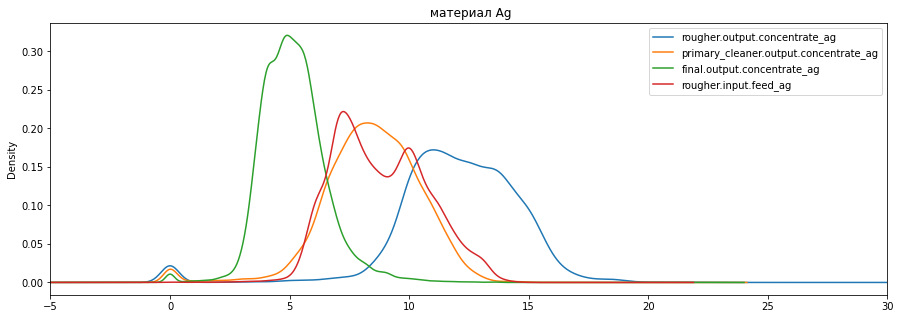

In [32]:
data_ag.plot(kind='kde', style='-', figsize=(15, 5), title=' материал Ag')
plt.xlim(-5,30)

На каждом этапе технологического процесса концентраия Ag сначала увеличивается, а потом идет на спад. Чем ближе технологический процесс к финальной очистке, тем меньше значение дисперсии. Есть аномальные нулевые значения. Это связано с недополучением с данных приборов или их остановкой. Этот процесс свидетильствует о стадии извлечения Ag.

Распределение концентрации материала Au.

In [33]:
data_au = gold_recovery_full_new_clean[['rougher.output.concentrate_au', 'primary_cleaner.output.concentrate_au', 'final.output.concentrate_au', 'rougher.input.feed_au']]

(-5.0, 60.0)

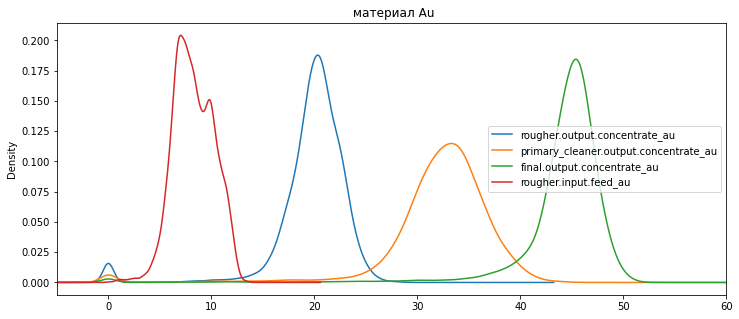

In [34]:
data_au.plot(kind='kde', style='-', figsize=(12, 5), title=' материал Au')
plt.xlim(-5,60)

На каждом этапе технологического процесса концентрация Au сначала увеличивается, а потом идет на спад. Есть аномальные нулевые значения. Это связано с недополучением данных с приборов или их остановкой. Этот процесс свидетельствует о стадии извлечения Au. Максимальной концентрации Au достигает на самом первом этапе технологического процесса, а именно непосредственно при добыче Au. Концентрация Au после начальной очистки и финальной находятся примерно на одном уровне. Самая низкая концентрация Au на этапе грунтовой очистки.

In [35]:
data_pb = gold_recovery_full_new_clean[['rougher.output.concentrate_pb', 'primary_cleaner.output.concentrate_pb', 'final.output.concentrate_pb', 'rougher.input.feed_pb']]

(-5.0, 20.0)

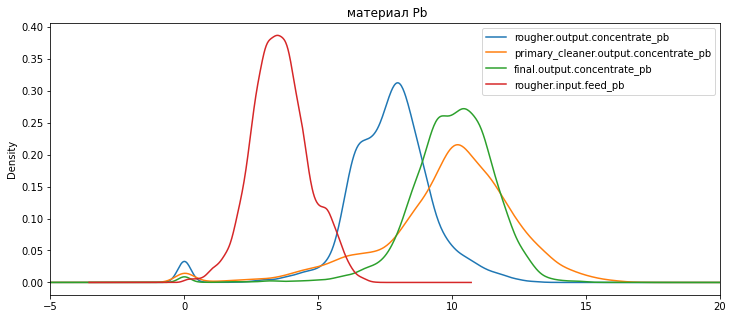

In [36]:
data_pb.plot(kind='kde', style='-', figsize=(12, 5), title=' материал Pb')
plt.xlim(-5,20)

На каждом этапе технологического процесса концентраия Pb сначала увеличивается, а потом идет на спад. Есть аномальные нулевые значения. Это связано с недополучением данных с приборов или их остановкой. Этот процесс свидетильствует о стадии извлечения Pb. Максимальная концентрация Pb на стадии добычи руды.

### Сравним распределения размеров гранул сырья на обучающей и тестовой выборках

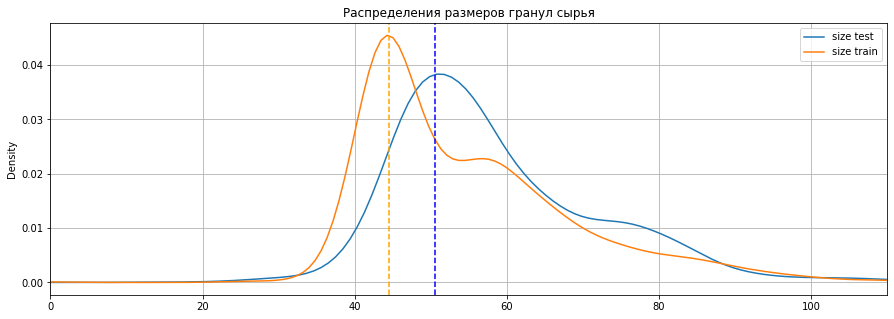

In [37]:
fig, ax = plt.subplots()
x = gold_recovery_train_new_clean['rougher.input.feed_size']
y = gold_recovery_test_new_clean['rougher.input.feed_size']
x.plot(kind = 'kde', figsize = (15,5), title='Распределения размеров гранул сырья')
y.plot(kind = 'kde')
plt.legend(labels=['size test','size train'])
ax.axvline(50.5, color="blue", linestyle="--")
ax.axvline(44.5, color="orange", linestyle="--")
ax.grid()
plt.xlim(0,110)
plt.show()

Распределение размеров гранул сырья на обучающей и тестовой выборках отличается на 6 значений. Дисперсия на обучающей выборке больше, чем на тестовой.

### Исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах

Расчитаем суммарную концентрацию всех веществ в сырье.

In [38]:
concentrate_raw_material = (gold_recovery_full_new_clean['rougher.input.feed_ag'] + gold_recovery_full_new_clean['rougher.input.feed_pb'] + gold_recovery_full_new_clean['rougher.input.feed_sol'] + gold_recovery_full_new_clean['rougher.input.feed_au'])

Расчитаем суммарную концентрацию всех веществ в черновом концентрате.

In [39]:
concentrate_rougher = (gold_recovery_full_new_clean['rougher.output.concentrate_ag'] + gold_recovery_full_new_clean['rougher.output.concentrate_pb'] + gold_recovery_full_new_clean['rougher.output.concentrate_sol'] + gold_recovery_full_new_clean['rougher.output.concentrate_au'] )

Расчитаем суммарную концентрацию всех веществ в финальном концентрате.

In [40]:
concentrate_final = (gold_recovery_full_new_clean['final.output.concentrate_ag'] + gold_recovery_full_new_clean['final.output.concentrate_pb'] + gold_recovery_full_new_clean['final.output.concentrate_sol']  + gold_recovery_full_new_clean[ 'final.output.concentrate_au'])

Сравним суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах.

(-10.0, 100.0)

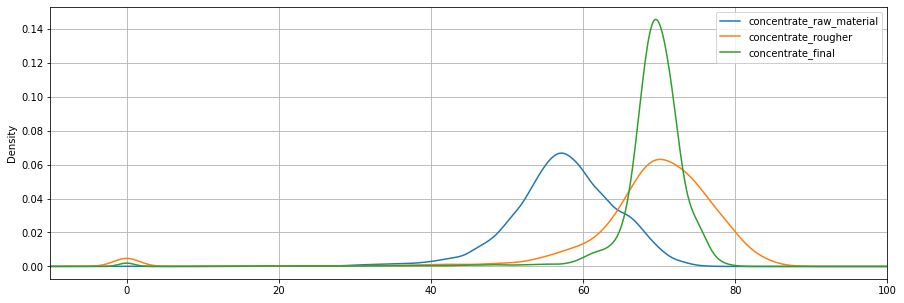

In [41]:
fig, ax = plt.subplots()

concentrate_raw_material.plot(kind = 'kde', figsize = (15,5), label = 'concentrate_raw_material')
concentrate_rougher.plot(kind = 'kde', figsize = (15,5), label = 'concentrate_rougher')
concentrate_final.plot(kind = 'kde', figsize = (15,5), label = 'concentrate_final')
ax.grid()
plt.legend()
plt.xlim(-10,100)

Суммарная концентрация веществ в сырье меньше, чем после флотаций и в финальном концентрате. В финальном концентрате распределение стремится к нормальному. Это указывает на работу технологического процесса. Присутствуют аномальные значения близкие к нулю.

Удалим аномальные значения всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах из обучающей выборки.

In [42]:
gold_recovery_full_new_clean = gold_recovery_full_new_clean[(gold_recovery_full_new_clean['rougher.input.feed_au'] > 0) & (gold_recovery_full_new_clean['rougher.input.feed_ag'] > 0) & (gold_recovery_full_new_clean['rougher.input.feed_pb'] > 0) & (gold_recovery_full_new_clean['rougher.input.feed_sol'] > 0)]
gold_recovery_full_new_clean = gold_recovery_full_new_clean[(gold_recovery_full_new_clean['rougher.output.concentrate_au'] > 0) & (gold_recovery_full_new_clean['rougher.output.concentrate_ag'] > 0) & (gold_recovery_full_new_clean['rougher.output.concentrate_pb'] > 0) & (gold_recovery_full_new_clean['rougher.output.concentrate_sol'] > 0)]
gold_recovery_full_new_clean = gold_recovery_full_new_clean[(gold_recovery_full_new_clean['primary_cleaner.output.concentrate_au'] > 0) & (gold_recovery_full_new_clean['primary_cleaner.output.concentrate_ag'] > 0) & (gold_recovery_full_new_clean['primary_cleaner.output.concentrate_pb'] > 0) & (gold_recovery_full_new_clean['primary_cleaner.output.concentrate_sol'] != 0)]
gold_recovery_full_new_clean = gold_recovery_full_new_clean[(gold_recovery_full_new_clean['final.output.concentrate_au'] > 0) & (gold_recovery_full_new_clean['final.output.concentrate_ag'] > 0) & (gold_recovery_full_new_clean['final.output.concentrate_pb'] > 0) & (gold_recovery_full_new_clean['final.output.concentrate_sol'] > 0)]

gold_recovery_train_new_clean = gold_recovery_train_new_clean[(gold_recovery_train_new_clean['rougher.input.feed_au'] > 0) & (gold_recovery_train_new_clean['rougher.input.feed_ag'] > 0) & (gold_recovery_train_new_clean['rougher.input.feed_pb'] > 0) & (gold_recovery_train_new_clean['rougher.input.feed_sol'] > 0)]
gold_recovery_train_new_clean = gold_recovery_train_new_clean[(gold_recovery_train_new_clean['rougher.output.concentrate_au'] > 0) & (gold_recovery_train_new_clean['rougher.output.concentrate_ag'] > 0) & (gold_recovery_train_new_clean['rougher.output.concentrate_pb'] > 0) & (gold_recovery_train_new_clean['rougher.output.concentrate_sol'] > 0)]
gold_recovery_train_new_clean = gold_recovery_train_new_clean[(gold_recovery_train_new_clean['primary_cleaner.output.concentrate_au'] > 0) & (gold_recovery_train_new_clean['primary_cleaner.output.concentrate_ag'] > 0) & (gold_recovery_train_new_clean['primary_cleaner.output.concentrate_pb'] > 0) & (gold_recovery_train_new_clean['primary_cleaner.output.concentrate_sol'] > 0)]
gold_recovery_train_new_clean = gold_recovery_train_new_clean[(gold_recovery_train_new_clean['final.output.concentrate_au'] > 0) & (gold_recovery_train_new_clean['final.output.concentrate_ag'] > 0) & (gold_recovery_train_new_clean['final.output.concentrate_pb'] > 0) & (gold_recovery_train_new_clean['final.output.concentrate_sol'] > 0)]

Посмотрим на размеры очищенных выборок.

In [43]:
gold_recovery_full_new_clean.shape

(18838, 87)

In [44]:
gold_recovery_train_new_clean.shape

(13716, 87)

***Вывод***

Посмотрели, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки, построили графики для каждого металла в отдельности. На каждом этапе технологического процесса концентраия Au сначала увеличивается, а потом идет на спад. Есть аномальные нулевые значения. Это связано с недополучением данных с приборов или их остановкой. Этот процесс свидетильствует о стадии извлечения Au. Максимальной концентрации Au достигает на самом первом этапе технологического процесса, а именно непосредственно при добыче Au. Концентрация Au после начальной очистки и финальной находятся примерно на одном уровне. Самая низкая концентрация Au на этапе грунтовой очистки. Сравнили распределения размеров гранул сырья на обучающей и тестовой выборках. Распределение размеров гранул сырья на обучающей и тестовой выборках отличается на 6 значений. Дисперсия на обучающей выборке больше, чем на тестовой. Исследовали суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. Суммарная концентрация веществ в сырье меньше, чем после флотаций и в финальном концентрате. В финальном концентрате распределение стремится к нормальному. Это указывает на работу технологического процесса. Присутствуют аномальные значения близкие к нулю. Удалили аномальные значения всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах из обучающей выборки.

## Модель

### Удалим из обучающей выборки признаки, отсутствующие в тестовой выборке

In [45]:
target_signs = del_signs - set(['rougher.output.recovery','final.output.recovery'])
train_full = gold_recovery_train_new_clean.drop(columns=target_signs, axis=1)

### Добавим в тестовую выборку целевые признаки: "rougher.output.recovery", "final.output.recovery", а так же столбец "date" для сортировки по индексу

In [46]:
full = gold_recovery_full_new_clean[['date', 'rougher.output.recovery', 'final.output.recovery']]
test_full = gold_recovery_test_new_clean.merge(full, how = 'left', on = 'date')

### Удалим столбец "date", так как он не информативен

In [47]:
test_full.drop(['date'], axis=1, inplace=True)
train_full.drop(['date'], axis=1, inplace=True)

### Напишем функцию для определения SMAPE

In [48]:
def calculation_smape(target, predict):
    smape = (1/len(target))*np.sum((np.abs(target - predict))/( (np.abs(target)+np.abs(predict))/2))*100
    return smape

In [49]:
smape_scorer = make_scorer(calculation_smape, best = False)

In [50]:
def calculation_final_smape(rougher, final):
    final = 0.25*rougher+0.75*final
    return final

### Подготовим данные для обучения модели

In [51]:
features_train_full = train_full.drop(['rougher.output.recovery','final.output.recovery'], axis=1)
target_rougher_train = train_full['rougher.output.recovery']
target_final_train = train_full['final.output.recovery']

### Произведем подбор параметров модели

In [52]:
smape_score = make_scorer(calculation_smape, greater_is_better= False )

### Создадим матрицу гиперпараметров

In [53]:
param_dist_dt = {"max_depth":range(1,101,10), "min_samples_leaf": [ 1, 0.5, 2]}

### Обучение и проверка моделей

***Дерво решений***

Проведем кросс-валидацию и обучение.

In [54]:
model_dt_cv_r = GridSearchCV(DecisionTreeRegressor(random_state = 12345),param_dist_dt, cv = 4, scoring = smape_score )
dt_cv_r = model_dt_cv_r.fit(features_train_full, target_rougher_train)
print("Лучшие параметры для Дерева решений : {}".format(dt_cv_r.best_params_))
print("Лучшее SMAPE для Дерева решений : {}".format(dt_cv_r.best_score_))

Лучшие параметры для Дерева решений : {'max_depth': 1, 'min_samples_leaf': 0.5}
Лучшее SMAPE для Дерева решений : -8.130619574436073


In [55]:
model_dt_r =DecisionTreeRegressor(random_state = 12345, max_depth = 1, min_samples_leaf = 1 )
dt_r = model_dt_r.fit(features_train_full, target_rougher_train)
predict_dt_r = model_dt_r.predict(features_train_full)
dt_scores_r = cross_val_score(dt_r, features_train_full, target_rougher_train, cv = 10, scoring = smape_score)

smape_dt_r = pd.Series(dt_scores_r)

print(smape_dt_r)
print(np.mean(smape_dt_r))

0    -9.060304
1   -11.849677
2   -10.312459
3    -8.234904
4    -7.739118
5    -5.402477
6    -8.319046
7    -8.227048
8    -9.089432
9    -7.724723
dtype: float64
-8.59591877570628


In [56]:
model_dt_cv_f = GridSearchCV(DecisionTreeRegressor(random_state = 12345),param_dist_dt, cv = 4, scoring = smape_score )
dt_cv_f = model_dt_cv_f.fit(features_train_full, target_final_train)
print("Лучшие параметры для Дерева решений : {}".format(dt_cv_f.best_params_))
print("Лучшее SMAPE для Дерева решений : {}".format(dt_cv_f.best_score_))

Лучшие параметры для Дерева решений : {'max_depth': 1, 'min_samples_leaf': 0.5}
Лучшее SMAPE для Дерева решений : -10.58735708885068


In [57]:
model_dt_f =DecisionTreeRegressor(random_state = 12345, max_depth = 1, min_samples_leaf = 0.5 )
dt_f = model_dt_f.fit(features_train_full, target_final_train)
predict_dt_f = model_dt_f.predict(features_train_full)
dt_scores_f = cross_val_score(dt_f, features_train_full, target_final_train, cv = 10, scoring = smape_score)

smape_dt_f = pd.Series(dt_scores_f)

print(smape_dt_f)
print(np.mean(smape_dt_f))

0   -10.122879
1    -9.243586
2    -9.896095
3    -6.789355
4    -8.075955
5   -11.908196
6   -10.954767
7   -12.631109
8   -11.514441
9   -10.797228
dtype: float64
-10.193361089175006


***Линейная регрессия***

In [58]:
model_lr_r = LinearRegression()
lr_r = model_lr_r.fit(features_train_full, target_rougher_train)
predict_lr_r = lr_r.predict(features_train_full)
scores_lr_r = cross_val_score(lr_r, features_train_full, target_rougher_train, cv = 10, scoring = smape_score)

smape_lr_r = pd.Series(scores_lr_r)

print(smape_lr_r)
print(np.mean(smape_lr_r))

0   -7.337032
1   -8.270350
2   -6.406632
3   -4.658892
4   -6.194164
5   -5.248249
6   -5.275410
7   -4.085996
8   -6.826668
9   -7.856232
dtype: float64
-6.215962537444928


In [59]:
model_lr_f = LinearRegression()
lr_f = model_lr_f.fit(features_train_full, target_final_train)
predict_lr_f = lr_r.predict(features_train_full)
scores_lr_f = cross_val_score(lr_r, features_train_full, target_final_train, cv = 10, scoring = smape_score)

smape_lr_f = pd.Series(scores_lr_f)

print(smape_lr_f)
print(np.mean(smape_lr_f))

0    -9.570528
1   -10.477257
2   -11.403522
3    -7.097693
4    -8.892625
5   -10.253067
6    -9.994720
7    -8.262408
8   -10.330798
9   -15.422750
dtype: float64
-10.1705367977712


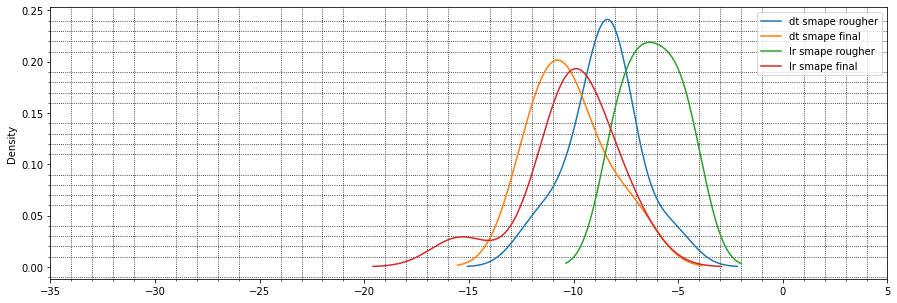

In [60]:
fig, ax = plt.subplots()
smape_dt_r.plot(kind = 'kde', figsize = (15,5), label = 'dt smape rougher', grid = True)
smape_dt_f.plot(kind = 'kde', figsize = (15,5), label = 'dt smape final', grid = True)
smape_lr_r.plot(kind = 'kde', figsize = (15,5), label = 'lr smape rougher', grid = True)
smape_lr_f.plot(kind = 'kde', figsize = (15,5), label = 'lr smape final', grid = True)

ax.minorticks_on()
ax.grid(which='major', color = 'k', linewidth = 2)
ax.grid(which='minor', color = 'k', linestyle = ':')
plt.legend()
plt.xlim(-35,5)

plt.show()

***Вывод***

Исходя из графика метрики SMAPE видно, что кривая линейной регрессии по признаку final.output.recovery близка к нормальному распределению, поэтому тестирование модели будем проводить на ней.

### Проведем тестирование на лучшей модели

In [61]:
features_test_lr = test_full.drop(['rougher.output.recovery','final.output.recovery'], axis=1)
target_test_lr_r = test_full['rougher.output.recovery']
target_test_lr_f = test_full['final.output.recovery']

In [62]:
model_test_lr_r = LinearRegression()
test_lr_r = model_test_lr_r.fit(features_train_full, target_rougher_train)
predict_test_lr_r = pd.Series(model_test_lr_r.predict(features_test_lr))
smape_test_lr_r = calculation_smape(target_test_lr_r, predict_test_lr_r)
print(smape_test_lr_r)

4.71024140994779


In [63]:
model_test_lr_f = LinearRegression()
test_lr_f = model_test_lr_f.fit(features_train_full, target_final_train)
predict_test_lr_f = pd.Series(model_test_lr_f.predict(features_test_lr))
smape_test_lr_f = calculation_smape(target_test_lr_f, predict_test_lr_f)
final_smape_lr_f = calculation_final_smape(smape_test_lr_r, smape_test_lr_f)
print(final_smape_lr_f)

7.0786702230710095


### Проверим модель на адекватность

In [64]:
dummy_lr_r = DummyRegressor(strategy="mean")
dummy_lr_r.fit(features_train_full, target_rougher_train)
dummy_predicted_lr_r = dummy_lr_r.predict(features_test_lr)
smape_lr_r = calculation_smape(target_test_lr_r, dummy_predicted_lr_r)

dummy_lr_f = DummyRegressor(strategy="mean")
dummy_lr_f.fit(features_train_full, target_final_train)
dummy_predicted_lr_f = dummy_lr_f.predict(features_test_lr)
smape_lr_f = calculation_smape(target_test_lr_f, dummy_predicted_lr_f)

final_smape_lr = calculation_final_smape(smape_lr_r, smape_lr_f)
print(final_smape_lr)

7.522739131628747


***Вывод***

Удалили из обучающей выборки признаки, отсутствующие в тестовой выборке. Добавили в тестовую выборку целевые признаки: "rougher.output.recovery", "final.output.recovery", а также столбец "date" для сортировки по индексу. Удали столбец "date", так он не информативен. Напишем функцию для определения SMAPE. Подготовили данные для обучения модели. Произвели подбор параметров модели. Создали матрицу гипперпараметров. Обучение и кросс-валидацию моделей проводили на "Дереве решений" и "Линейной регрессии". Построили график SMAPE. Исходя из графика метрики SMAPE видно, что кривая линейной регрессии по признаку final.output.recovery близка к нормальному распределению, поэтому тестирование модели будем проводить на ней. Провели тестирование модели на "Линейной регрессии". Финальный показатель SMAPE = 7.079. Проверили модель на адекватность. Показатель модели SMAPE 'DummyClassifier' немного выше, чем у модели 'LinearRegression', модель можно считать адекватной и эффективной.